In [1]:
!pip install numpy matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Image width: 1600px
Image height: 654px
Number of channels: 3


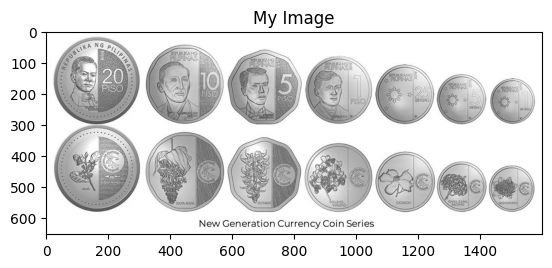

In [26]:
import cv2 
import matplotlib.pyplot as plt

# Load an image (change 'image.jpg' to your image file path)
image = cv2.imread('coins.jpg')

# Check if the image was loaded properly
if image is None:
    print("Error: Could not load image.")
else:
    # Get the size of the image
    height, width, channels = image.shape #[rows, columns, rbg--> [r,g,b]]
    print(f"Image width: {width}px")
    print(f"Image height: {height}px")
    print(f"Number of channels: {channels}")

    # Show the image in a window
    
    image_g = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = cv2.cvtColor(image_g, cv2.COLOR_BGR2RGB)

    # Show the image in the notebook
    plt.imshow(image_gray)
    plt.title("My Image")
    plt.axis('on')  # You can use 'off' to hide axes
    plt.show()


Detected objects: 0


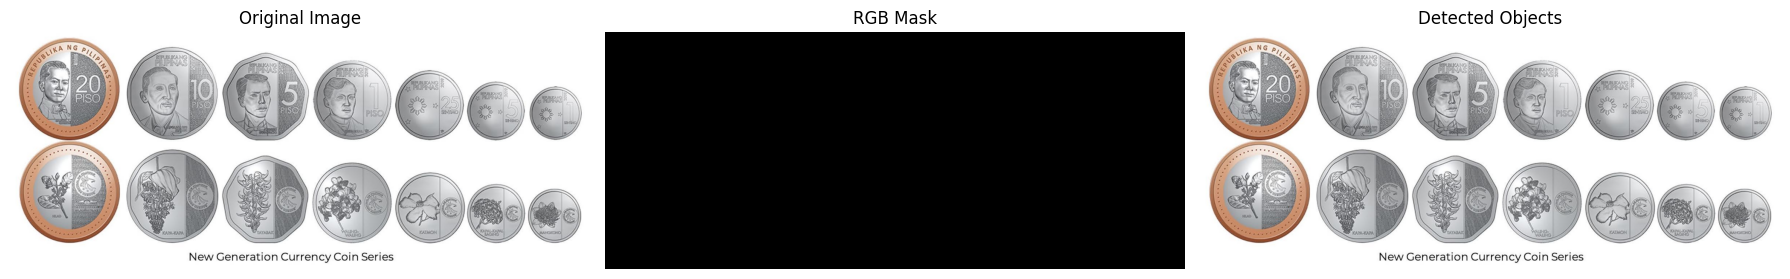

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image (replace with your own image path)
image = cv2.imread('coins.jpg')  # Make sure the image is in your working directory
if image is None:
    print("Error: Could not load image.")
else:
    # Convert to RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Define RGB color range (example: red objects)
    lower_rgb = np.array([150, 0, 0])
    upper_rgb = np.array([255, 80, 80])

    # Create mask
    mask = cv2.inRange(rgb_image, lower_rgb, upper_rgb)

    # Clean up mask
    kernel = np.ones((5, 5), np.uint8)
    mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours
    output_image = rgb_image.copy()
    count = 0
    for contour in contours:
        if cv2.contourArea(contour) > 100:
            count += 1
            cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 2)

    print(f"Detected objects: {count}")

    # Plotting images inline
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(rgb_image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(mask_cleaned, cmap='gray')
    axs[1].set_title("RGB Mask")
    axs[1].axis('off')

    axs[2].imshow(output_image)
    axs[2].set_title("Detected Objects")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


60073.0
59528.0
11859.0
10099.0


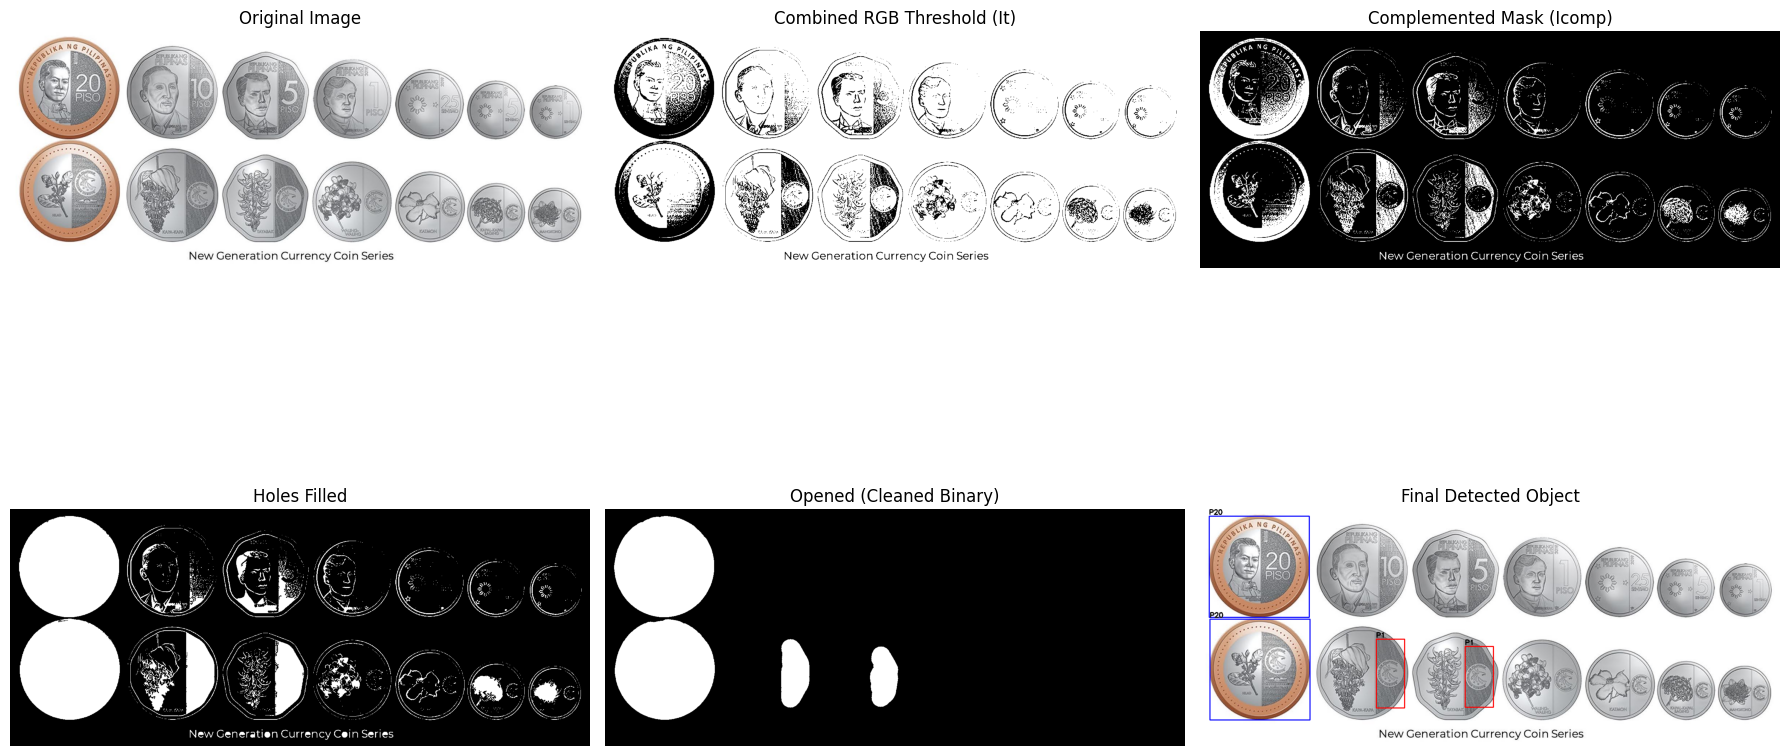

small: 2
medium: 0
large: 2
count: 4


In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import disk, opening
from skimage.util import invert

# Load image
image = cv2.imread('coins.jpg')
if image is None:
    raise FileNotFoundError("Image not found.")

# Convert to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Extract channels
rmat = image_rgb[:, :, 0]
gmat = image_rgb[:, :, 1]
bmat = image_rgb[:, :, 2]

# Threshold levels
levelr = 0.5 * 255
levelg = 0.45 * 255
levelb = 0.5 * 255

# Threshold RGB channels
Ired = (rmat > levelr).astype(np.uint8)
Igreen = (gmat > levelg).astype(np.uint8)
Iblue = (bmat > levelb).astype(np.uint8)

# Combine channels
It = cv2.bitwise_and(cv2.bitwise_and(Ired, Igreen), Iblue)

# Invert mask
Icomp = cv2.bitwise_not(It * 255)

# Fill holes
flood_fill = Icomp.copy()
h, w = flood_fill.shape
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(flood_fill, mask, (0, 0), 255)
filled = cv2.bitwise_or(Icomp, cv2.bitwise_not(flood_fill))

# Morphological open
opened = opening(filled // 255, disk(25)).astype(np.uint8)

# Label connected components
label_image = label(opened)
regions = regionprops(label_image)

###
for region in regions:
        area = region.area
        centroid = region.centroid
        print(area)

# Classify objects
small, medium, large = [], [], []
for region in regions:
    area = region.area
    if area < 14000:
        small.append(region)
    elif area < 45000:
        medium.append(region)
    else:
        large.append(region)

# Draw boxes on copy of image
output_img = image_rgb.copy()
for region in small:
    minr, minc, maxr, maxc = region.bbox
    cv2.rectangle(output_img, (minc, minr), (maxc, maxr), (255, 0, 0), 2)
    cv2.putText(output_img, 'P1', (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

for region in medium:
    minr, minc, maxr, maxc = region.bbox
    cv2.rectangle(output_img, (minc, minr), (maxc, maxr), (0, 255, 0), 2)
    cv2.putText(output_img, 'P5', (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

for region in large:
    minr, minc, maxr, maxc = region.bbox
    cv2.rectangle(output_img, (minc, minr), (maxc, maxr), (0, 0, 255), 2)
    cv2.putText(output_img, 'P20', (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

# Display results side-by-side
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

axs[0, 0].imshow(image_rgb)
axs[0, 0].set_title("Original Image")
axs[0, 0].axis("off")

axs[0, 1].imshow(It, cmap='gray')
axs[0, 1].set_title("Combined RGB Threshold (It)")
axs[0, 1].axis("off")

axs[0, 2].imshow(Icomp, cmap='gray')
axs[0, 2].set_title("Complemented Mask (Icomp)")
axs[0, 2].axis("off")

axs[1, 0].imshow(filled, cmap='gray')
axs[1, 0].set_title("Holes Filled")
axs[1, 0].axis("off")

axs[1, 1].imshow(opened, cmap='gray')
axs[1, 1].set_title("Opened (Cleaned Binary)")
axs[1, 1].axis("off")

axs[1, 2].imshow(output_img)
axs[1, 2].set_title("Final Detected Object")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()

# Display total value
total_value = len(small)  + len(medium)  + len(large) 
print(f"small: {len(small)}")
print(f"medium: {len(medium)}")
print(f"large: {len(large)}")
print(f"count: {total_value}")


In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import disk, opening
from skimage.util import invert

# Load image
image = cv2.imread('coins.jpg')
if image is None:
    raise FileNotFoundError("Image not found.")

# Convert to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

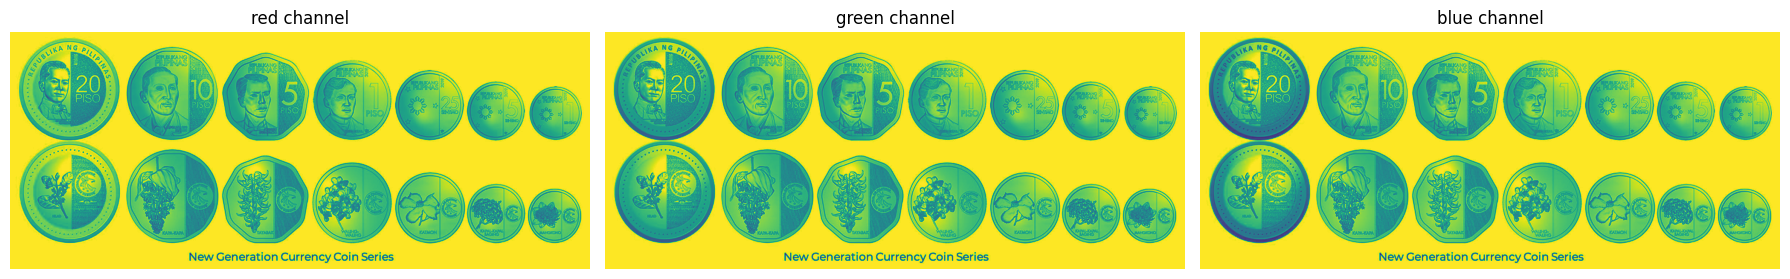

In [30]:
# Extract channels
rmat = image_rgb[:, :, 0]
gmat = image_rgb[:, :, 1]
bmat = image_rgb[:, :, 2]
#show image for each channel
fig, axs = plt.subplots(1, 3, figsize=(18, 12))
axs[0].imshow(rmat)
axs[0].set_title("red channel")
axs[0].axis("off")

axs[1].imshow(gmat)
axs[1].set_title("green channel")
axs[1].axis("off")

axs[2].imshow(bmat)
axs[2].set_title("blue channel")
axs[2].axis("off")

plt.tight_layout()
plt.show()

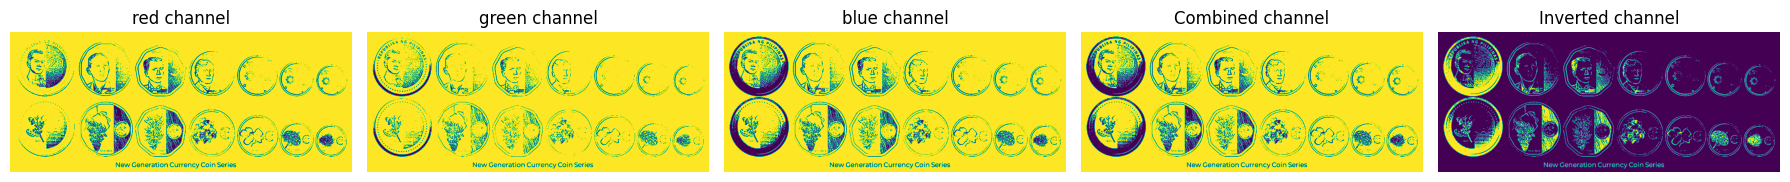

In [31]:
# Threshold levels
levelr = 0.5 * 255
levelg = 0.45 * 255
levelb = 0.5 * 255

# Threshold RGB channels
Ired = (rmat > levelr).astype(np.uint8)
Igreen = (gmat > levelg).astype(np.uint8)
Iblue = (bmat > levelb).astype(np.uint8)

# Combine channels
It = cv2.bitwise_and(cv2.bitwise_and(Ired, Igreen), Iblue)

# Invert mask
Icomp = cv2.bitwise_not(It * 255)

#show image for each channel
fig, axs = plt.subplots(1, 5, figsize=(18, 12))
axs[0].imshow(Ired)
axs[0].set_title("red channel")
axs[0].axis("off")

axs[1].imshow(Igreen)
axs[1].set_title("green channel")
axs[1].axis("off")

axs[2].imshow(Iblue)
axs[2].set_title("blue channel")
axs[2].axis("off")

axs[3].imshow(It)
axs[3].set_title("Combined channel")
axs[3].axis("off")

axs[4].imshow(Icomp)
axs[4].set_title("Inverted channel")
axs[4].axis("off")

plt.tight_layout()
plt.show()

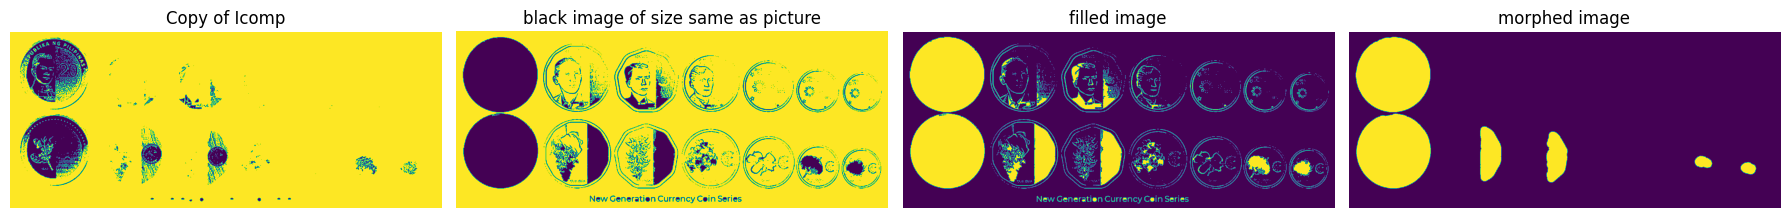

60104.0
59555.0
12456.0
11045.0
2168.0
1934.0


In [32]:
# Fill holes
flood_fill = Icomp.copy()
h, w = flood_fill.shape
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(flood_fill, mask, (0, 0), 255)
filled = cv2.bitwise_or(Icomp, cv2.bitwise_not(flood_fill))

# Morphological open
opened = opening(filled // 255, disk(15)).astype(np.uint8)

# Label connected components
label_image = label(opened)
regions = regionprops(label_image)

#show image for each channel
fig, axs = plt.subplots(1, 4, figsize=(18, 12))
axs[0].imshow(flood_fill)
axs[0].set_title("Copy of Icomp")
axs[0].axis("off")

axs[1].imshow(mask)
axs[1].set_title("black image of size same as picture")
axs[1].axis("off")

axs[2].imshow(filled)
axs[2].set_title("filled image")
axs[2].axis("off")

axs[3].imshow(opened)
axs[3].set_title("morphed image")
axs[3].axis("off")


plt.tight_layout()
plt.show()
###
for region in regions:
        area = region.area
        print(area)

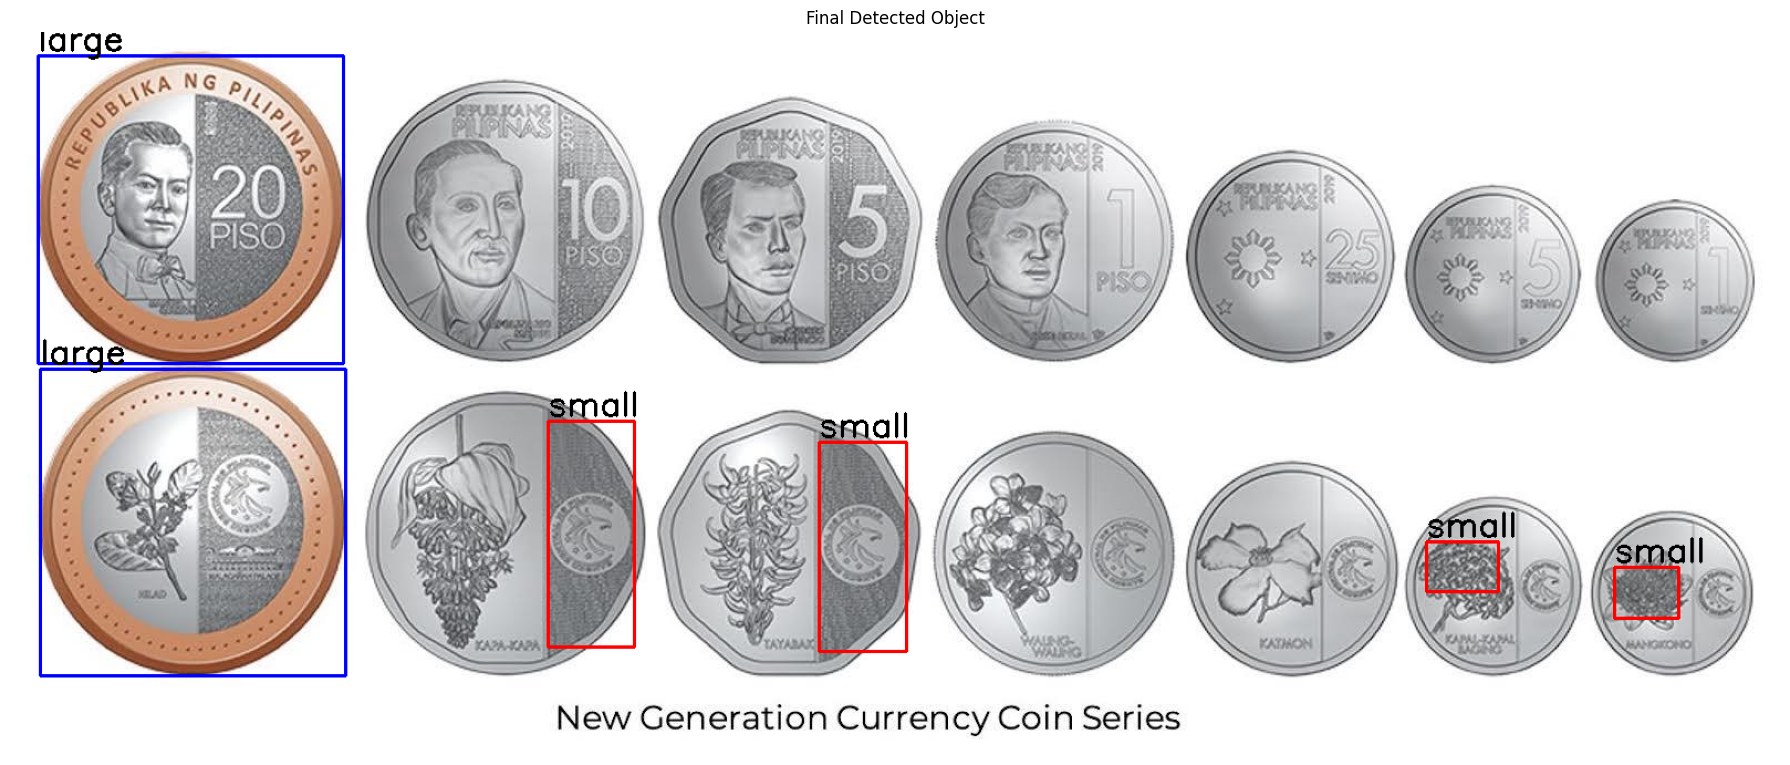

small: 4
medium: 0
large: 2
count: 6


In [33]:
# Classify objects
small, medium, large = [], [], []
for region in regions:
    area = region.area
    if area < 14000:
        small.append(region)
    elif area < 45000:
        medium.append(region)
    else:
        large.append(region)

# Draw boxes on copy of image
output_img = image_rgb.copy()
for region in small:
    minr, minc, maxr, maxc = region.bbox
    cv2.rectangle(output_img, (minc, minr), (maxc, maxr), (255, 0, 0), 2)
    cv2.putText(output_img, 'small', (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

for region in medium:
    minr, minc, maxr, maxc = region.bbox
    cv2.rectangle(output_img, (minc, minr), (maxc, maxr), (0, 255, 0), 2)
    cv2.putText(output_img, 'medium', (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

for region in large:
    minr, minc, maxr, maxc = region.bbox
    cv2.rectangle(output_img, (minc, minr), (maxc, maxr), (0, 0, 255), 2)
    cv2.putText(output_img, 'large', (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

# Display results side-by-side
fig, axs = plt.subplots(1, 1, figsize=(18, 12))

axs.imshow(output_img)
axs.set_title("Final Detected Object")
axs.axis("off")

plt.tight_layout()
plt.show()

# Display total value
total_value = len(small)  + len(medium)  + len(large) 
print(f"small: {len(small)}")
print(f"medium: {len(medium)}")
print(f"large: {len(large)}")
print(f"count: {total_value}")

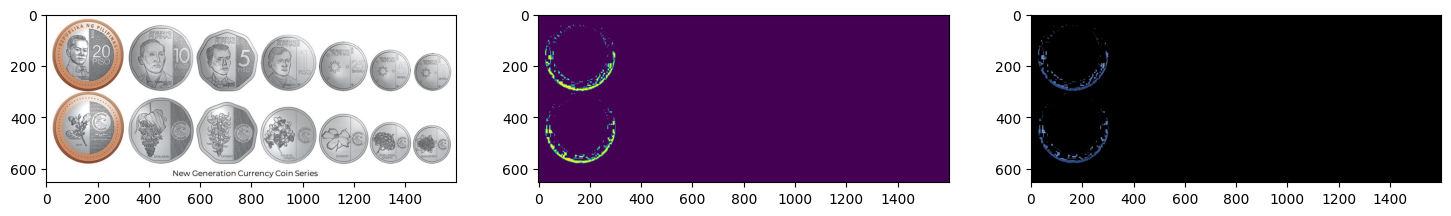

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the image
image = cv2.imread('coins.jpg')
image = cv2.resize(image, (1600, 654))  # Resize if needed

# Convert to HSV
image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the red color range in HSV
# Red can span across the 0 and 180 boundaries, so we need two ranges
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([10, 255, 255])

lower_red2 = np.array([160, 100, 100])
upper_red2 = np.array([180, 255, 255])

# Create masks
mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

# Combine both masks
red_mask = cv2.bitwise_or(mask1, mask2)

# Apply the mask to the original image
red_result = cv2.bitwise_and(image, image, mask=red_mask)

fig, axs = plt.subplots(1, 3, figsize=(18, 12))
# Display the results
axs[0].imshow(image_rgb)
axs[1].imshow(red_mask)
axs[2].imshow(red_result)


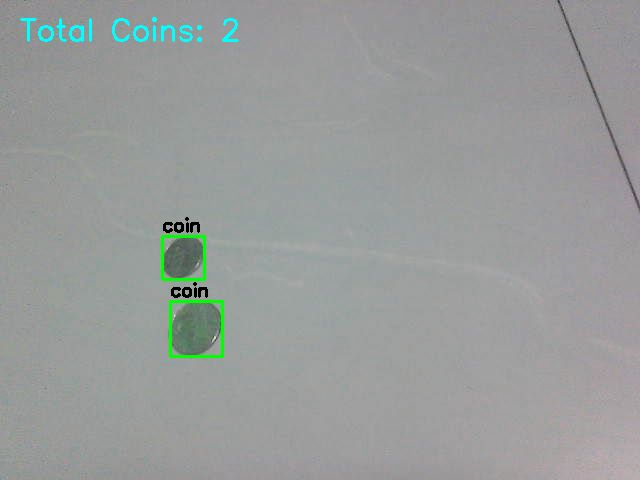

KeyboardInterrupt: 

In [38]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
from IPython.display import display, clear_output, Image as IPyImage  # NOTE: Image alias
# No matplotlib import here

cap = cv2.VideoCapture(1)
if not cap.isOpened():
    raise RuntimeError("Error: Could not open camera")

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Otsu threshold (invert so coins become white blobs if background is darker)
        _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Morphology to clean up noise/holes
        kernel = np.ones((5, 5), np.uint8)
        mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)

        # Label connected components
        labeled = label(mask_cleaned)
        regions = regionprops(labeled)

        coin_count = 0
        output_img = frame.copy()

        for region in regions:
            if region.area > 500:  # ignore tiny noise
                perimeter = region.perimeter if region.perimeter > 0 else 1.0
                circularity = 4.0 * np.pi * (region.area / (perimeter ** 2))
                if circularity > 0.7:  # round-ish objects
                    minr, minc, maxr, maxc = region.bbox
                    cv2.rectangle(output_img, (minc, minr), (maxc, maxr), (0, 255, 0), 2)
                    cv2.putText(output_img, "coin", (minc, max(minr - 5, 15)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
                    coin_count += 1

        cv2.putText(output_img, f"Total Coins: {coin_count}", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

        # For notebook display: encode to JPEG and show via IPython.display
        # (avoids Matplotlib/PIL figure saving on every frame)
        rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
        ok, buf = cv2.imencode(".jpg", rgb, [int(cv2.IMWRITE_JPEG_QUALITY), 80])
        if not ok:
            continue

        clear_output(wait=True)
        display(IPyImage(data=buf.tobytes()))

        # Stop with 'q' in the cell's stdin (won't work in all notebooks).
        # If this doesn't work in your environment, just interrupt the cell to stop.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
finally:
    cap.release()
    cv2.destroyAllWindows()
